Schema Defined using StateGraph

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

## TypedDict

In [2]:
from typing import TypedDict, Literal

class TypedDictState(TypedDict):
   name: str
   mood: Literal["happy", "sad", "neutral"]


In [8]:
from langgraph.types import Command
import random
from langgraph.graph import StateGraph, START, END



def node_1(state):
    print("-----Node 1-----")
    return {"name" : state["name"] + " is ..... "}

def decide_mood(state) -> Literal["node_2", "node_3"]:
    print("-----Decide Mood-----")
    if random.random() < 0.5:
        return "node_2"
    else:
        return "node_3"

def node_2(state) -> Command[Literal["__end__"]]:
    print("-----Node 2-----")
    return Command(
        update = {"mood" : "happy"},
        goto = END
    )

def node_3(state) -> Command[Literal["__end__"]]:
    print("-----Node 3-----")
    return Command(
        update = {"mood" : "sad"},
        goto = END
    )


In [9]:
workflow = StateGraph(TypedDictState)

#nodes
workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)
workflow.add_node("node_3", node_3)

#edges
workflow.add_edge(START, "node_1")
workflow.add_conditional_edges("node_1", decide_mood)

graph = workflow.compile()


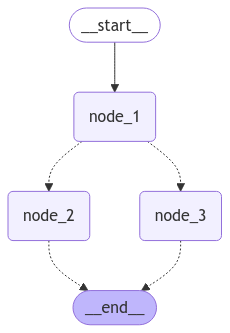

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
for event in graph.stream({"name" : "Hrithik"}):
    print(event)

-----Node 1-----
-----Decide Mood-----
{'node_1': {'name': 'Hrithik is ..... '}}
-----Node 3-----
{'node_3': {'mood': 'sad'}}


In [17]:
result = graph.invoke({"name" : "Hrithik"})
print(result)

-----Node 1-----
-----Decide Mood-----
-----Node 3-----
{'name': 'Hrithik is ..... ', 'mood': 'sad'}


In [22]:
result = graph.invoke({"name" : "Hrithik"})
print(result)

-----Node 1-----
-----Decide Mood-----
-----Node 2-----
{'name': 'Hrithik is ..... ', 'mood': 'happy'}


# DataClass


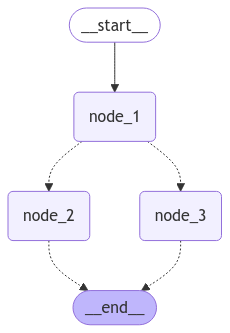

In [23]:
from dataclasses import dataclass

@dataclass
class DataClassState:
    name: str
    mood: Literal["happy", "sad", "neutral"]


def node_1(state):
    print("-----Node 1-----")
    return {"name" : state.name + " is ..... "}

def decide_mood(state) -> Literal["node_2", "node_3"]:
    print("-----Decide Mood-----")
    if random.random() < 0.5:
        return "node_2"
    else:
        return "node_3"


def node_2(state) -> Command[Literal["__end__"]]:
    print("-----Node 2-----")
    return Command(
        update = {"mood" : "happy"},
        goto = END
    )

def node_3(state) -> Command[Literal["__end__"]]:
    print("-----Node 3-----")
    return Command(
        update = {"mood" : "sad"},
        goto = END
    )

workflow = StateGraph(DataClassState)

#nodes
workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)
workflow.add_node("node_3", node_3)

#edges
workflow.add_edge(START, "node_1")
workflow.add_conditional_edges("node_1", decide_mood)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [29]:
result = graph.invoke(DataClassState(name="Hrithik", mood="neutral"))
print(result)


-----Node 1-----
-----Decide Mood-----
-----Node 3-----
{'name': 'Hrithik is ..... ', 'mood': 'sad'}


# Pydantic

Pydantic is a data validation and settings management library using Python type annotations.

It's particularly well-suited for defining state schemas in LangGraph due to its validation capabilities.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [32]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: Literal["happy", "sad", "neutral"]

    @field_validator("mood")
    def validate_mood(cls, v):
        if v not in ["happy", "sad", "neutral"]:
            raise ValueError("Invalid mood")
        return v
    

try:
    PydanticState(name="Hrithik", mood="mad")
    print("Validation passed")
except ValidationError as e:
    print(e)

1 validation error for PydanticState
mood
  Input should be 'happy', 'sad' or 'neutral' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/literal_error


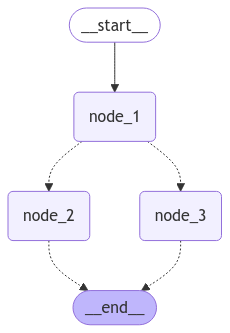

In [33]:
workflow = StateGraph(PydanticState)

#nodes
workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)
workflow.add_node("node_3", node_3)

#edges
workflow.add_edge(START, "node_1")
workflow.add_conditional_edges("node_1", decide_mood)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))




In [34]:
result = graph.invoke(PydanticState(name="Hrithik", mood="good"))
print(result)

ValidationError: 1 validation error for PydanticState
mood
  Input should be 'happy', 'sad' or 'neutral' [type=literal_error, input_value='good', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/literal_error

In [41]:
result = graph.invoke(PydanticState(name="Hrithik", mood="happy"))
print(result)

-----Node 1-----
-----Decide Mood-----
-----Node 2-----
{'name': 'Hrithik is ..... ', 'mood': 'happy'}
